In [240]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred

from scipy import stats
from scipy.stats import shapiro

from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA 

from sklearn.pipeline import Pipeline
from sklearn import svm

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, recall_score, precision_score, adjusted_rand_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import Lasso, Ridge, LinearRegression, ElasticNet

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from statsmodels.stats.outliers_influence import variance_inflation_factor

import xgboost as xgb

mm_scaler = MinMaxScaler()
st_scaler = StandardScaler()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [288]:
df_quarter = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=0)
df_month = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=1)
df_q_add = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=2)
df_mon_chg = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=3)
df_month_omiss = pd.read_excel('./new_data/new_test2.xlsx', sheet_name=4)


<Axes: >

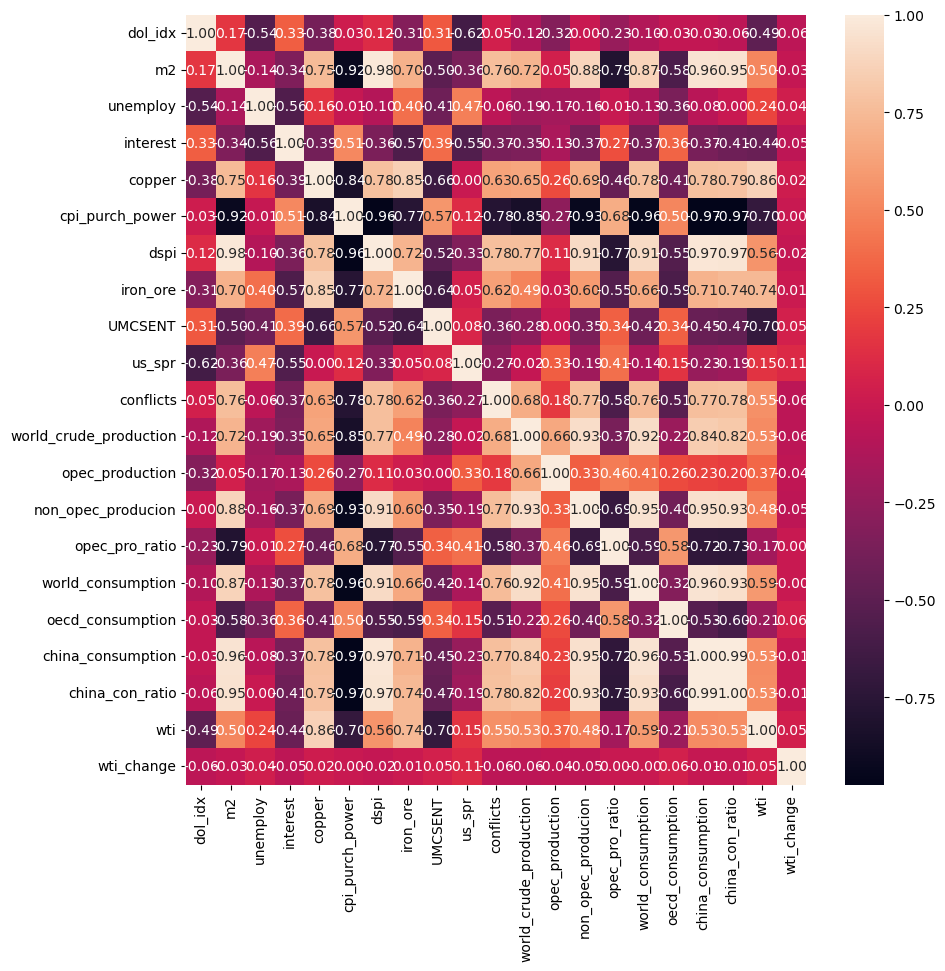

In [242]:
df_month_corr = df_month.iloc[:, 5:].corr(method='pearson')
plt.figure(figsize=(10,10))
plt.tight_layout()
sns.heatmap(df_month_corr, annot=True, fmt='.2f')

In [273]:
cols = ['date', 'year', 'quarter', 'month', 'total_manu', 'dol_idx', 'm2',
       'unemploy', 'interest', 'copper', 'cpi_purch_power', 'dspi', 'iron_ore',
       'UMCSENT', 'us_spr', 'conflicts', 'world_crude_production',
       'opec_production', 'non_opec_producion', 'opec_pro_ratio',
       'world_consumption', 'oecd_consumption', 'china_consumption',
       'china_con_ratio', 'wti', 'wti_change']

filter = ['date', 'year', 'quarter', 'month', 'dol_idx', 'm2',
       'unemploy', 'interest', 'copper', 'cpi_purch_power',
       'UMCSENT', 'us_spr', 'conflicts', 'world_crude_production',
       'opec_pro_ratio',
       'world_consumption', 
       'china_con_ratio',]

df_vif = df_month.dropna()[filter].iloc[:, 4:]

variance_inflation_factor(df_vif.values, 0)


# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = df_vif.columns
vif_data["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]

print(vif_data)

                   feature          VIF
0                  dol_idx   308.036640
1                       m2   184.308505
2                 unemploy    46.935449
3                 interest    11.678906
4                   copper    41.439204
5          cpi_purch_power   900.301971
6                  UMCSENT   210.060080
7                   us_spr   413.806218
8                conflicts    10.446079
9   world_crude_production  3276.501636
10          opec_pro_ratio  2043.040560
11       world_consumption  2025.531398
12         china_con_ratio   596.288853


Mean Squared Error: 214.1827010234492
Mean Absolute Error: 14.048268015170644
Root Mean Squared Error: 14.634982098501153
R-squared Score: -15.340840098391155


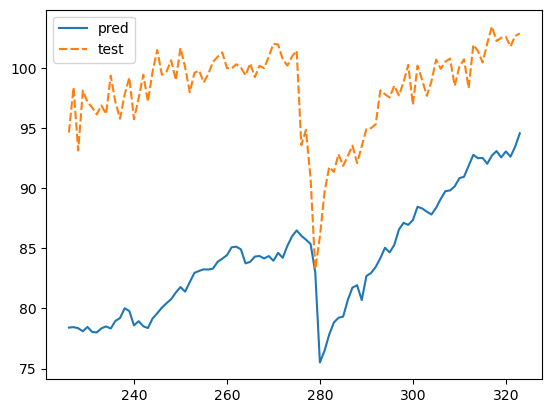

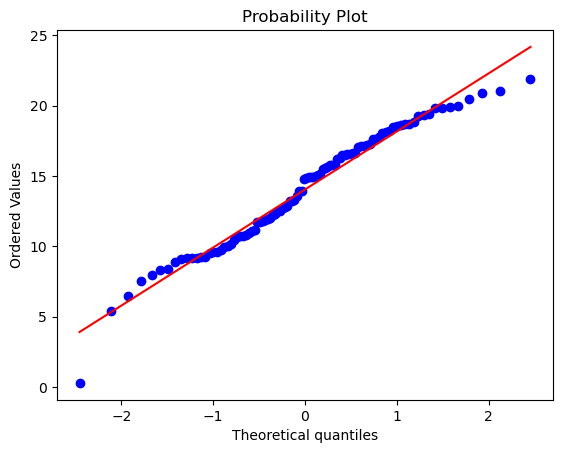

Statistics=0.973, p=0.040


In [274]:
# 일반 선형 회귀 모델

df_month = df_month.dropna()[filter]

df_X = df_month.iloc[:,4:-2]
df_y = df_month.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lm = LinearRegression()
lm.fit(X_train_scaled, y_train)
pred = lm.predict(X_test_scaled)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")


df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
sns.lineplot(df_plot)
plt.show()


residuals = y_test - pred

stats.probplot(residuals, plot=plt)
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

Mean Squared Error: 209.01357769315894
Mean Absolute Error: 14.060282971301627
Root Mean Squared Error: 14.457301881511603
R-squared Score: -14.946467362472166


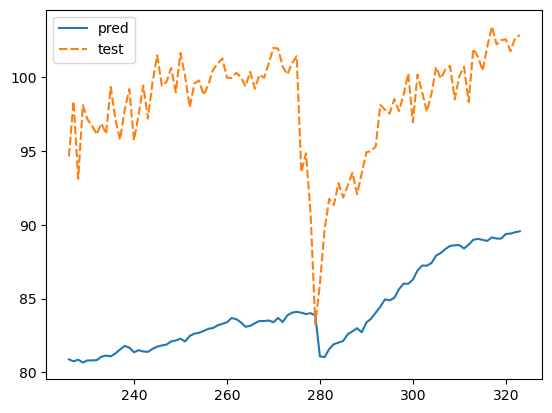

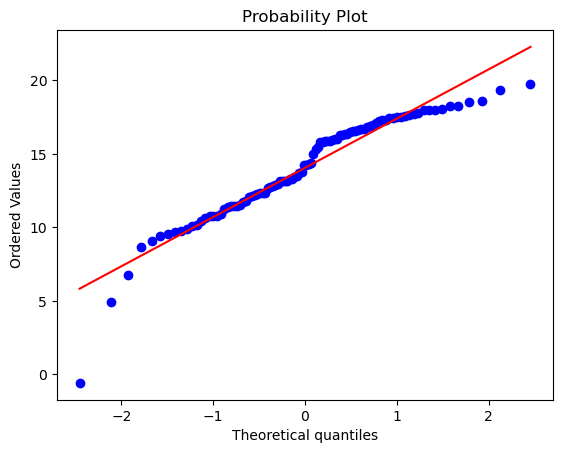

Statistics=0.929, p=0.000


In [275]:
# LASSO 모델

# df_X = df_month.iloc[:,4:-2]
# df_y = df_month.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lasso = Lasso(alpha=3)
lasso.fit(X_train_scaled, y_train)
pred = lasso.predict(X_test_scaled)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
sns.lineplot(df_plot)
plt.show()

residuals = y_test - pred

stats.probplot(residuals, plot=plt)
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

Mean Squared Error: 207.82562821210666
Mean Absolute Error: 14.048268015170672
Root Mean Squared Error: 14.416158580291306
R-squared Score: -14.855834027370483


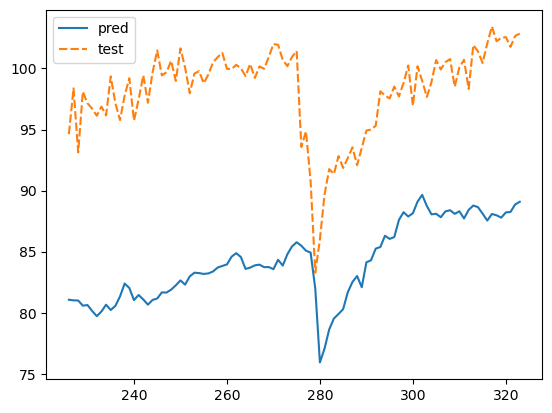

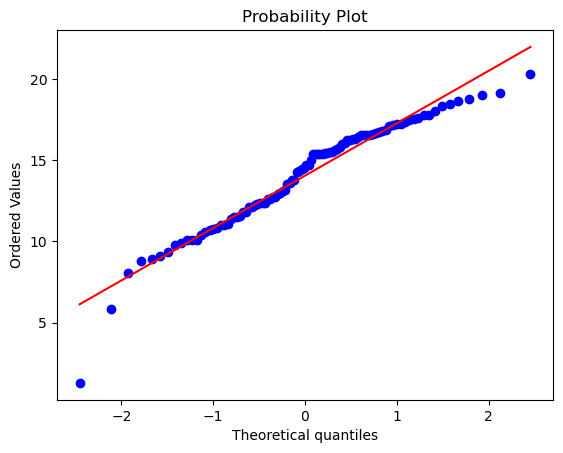

Statistics=0.956, p=0.002


In [276]:
# Ridge 모델

# df_X = df_month.iloc[:,4:-4]
# df_y = df_month.iloc[:,-2]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

train_scaler = StandardScaler()
test_scaler = StandardScaler()
X_train_scaled = train_scaler.fit_transform(X_train)
X_test_scaled = test_scaler.fit_transform(X_test)

ridge = Ridge(alpha=10)
ridge.fit(X_train_scaled, y_train)
pred = ridge.predict(X_test_scaled)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
sns.lineplot(df_plot)
plt.show()

residuals = y_test - pred

stats.probplot(residuals, plot=plt)
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

In [277]:
df_result = pd.DataFrame(columns=['name', 'lasso','ridge'])
df_result['name'] = df_X.columns.tolist()
df_result['lasso'] = lasso.coef_.tolist()
df_result['ridge'] = ridge.coef_.tolist()
# df_result['year'] = df_month.iloc[]
df_result

,name,lasso,ridge
0,dol_idx,0.000000,-0.019276
1,m2,0.209634,1.308688
2,unemploy,0.000000,-0.450200
3,interest,0.000000,-0.156815
4,copper,0.000000,0.685750
5,cpi_purch_power,-2.595182,-1.754904
6,UMCSENT,0.000000,0.024334
7,us_spr,0.000000,0.935798
8,conflicts,0.000000,0.088132
9,world_crude_production,0.760534,2.055858


Mean Squared Error: 208.84396910732923
Mean Absolute Error: 14.027356722463912
Root Mean Squared Error: 14.451434845970459
R-squared Score: -14.92876762640809


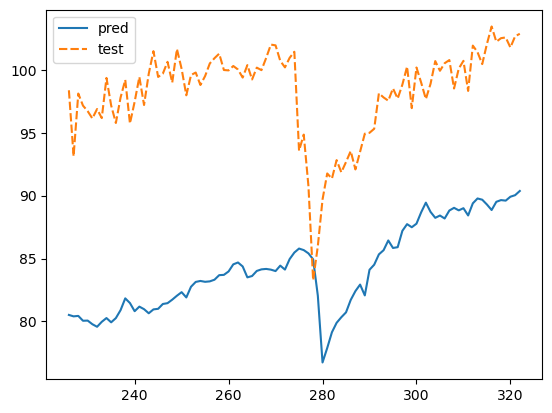

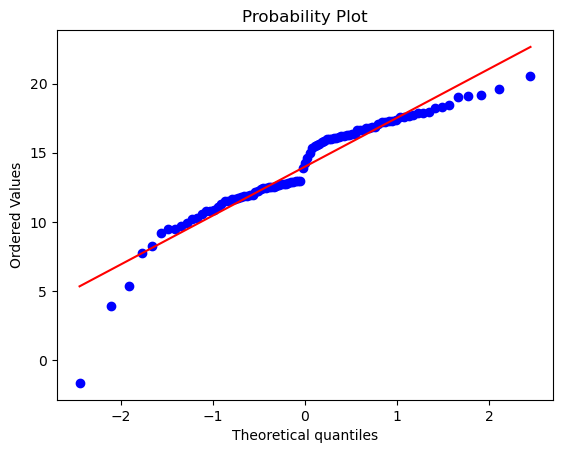

Statistics=0.925, p=0.000


In [278]:
# Ridge 모델 / 한달 후 유가와 비교

df_month = df_month.dropna()

df_X = df_month.iloc[:,4:-2]
df_y = df_month.iloc[:,-2]

df_X = df_X.iloc[:-1,:]
df_y = df_y.iloc[1:]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

ridge = Ridge(alpha=2)
ridge.fit(X_train_scaled, y_train)
pred = ridge.predict(X_test_scaled)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
sns.lineplot(df_plot)
plt.show()

residuals = y_test - pred

stats.probplot(residuals, plot=plt)
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

Mean Squared Error: 210.75901472900358
Mean Absolute Error: 14.01115719194958
Root Mean Squared Error: 14.517541621397323
R-squared Score: -15.074830339312882


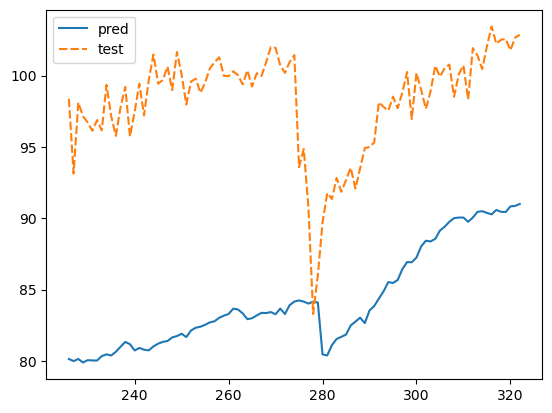

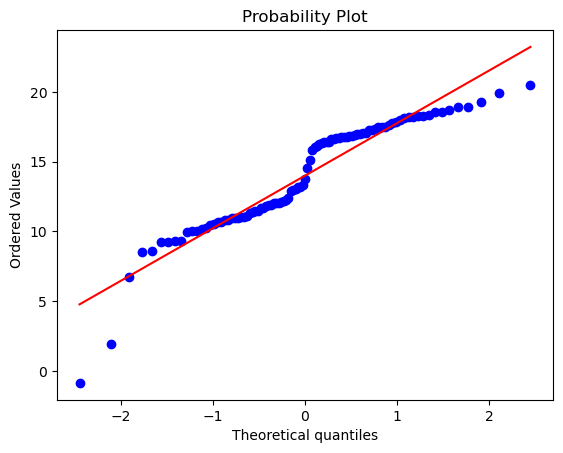

Statistics=0.913, p=0.000


In [279]:
# LASSO 모델 / 한달 후 유가와 비교

# df_X = df_month.iloc[:-1,4:-1]
# df_y = df_month.iloc[1:,-1]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lasso = Lasso(alpha=2)
lasso.fit(X_train_scaled, y_train)
pred = lasso.predict(X_test_scaled)

mse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

# 성능 평가 지표 계산
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred)

# 결과 출력
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared Score: {r2}")

df_plot = pd.DataFrame(pred, columns=['pred'])
df_plot['test'] = y_test.reset_index(drop=True)
df_plot.index = y_test.index
sns.lineplot(df_plot)
plt.show()


residuals = y_test - pred

stats.probplot(residuals, plot=plt)
plt.show()

stat, p = shapiro(residuals)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# p-value가 0.05보다 크면 정규성을 따른다고 해석할 수 있습니다.

In [281]:
df_result = pd.DataFrame(columns=['name', 'lasso','ridge'])
df_result['name'] = df_X.columns.tolist()
df_result['lasso'] = lasso.coef_.tolist()
df_result['ridge'] = ridge.coef_.tolist()
# df_result['year'] = df_month.iloc[]
df_result

,name,lasso,ridge
0,dol_idx,0.000000,-0.051701
1,m2,0.609937,0.867200
2,unemploy,0.000000,-0.332894
3,interest,0.000000,-0.019542
4,copper,0.000000,0.422637
5,cpi_purch_power,-2.975219,-2.905128
6,UMCSENT,0.000000,0.329619
7,us_spr,0.000000,0.912162
8,conflicts,0.000000,0.189166
9,world_crude_production,1.023089,1.780981


In [282]:
def get_tables(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [289]:
# 로지스틱 회귀 Ridge

from sklearn.linear_model import LogisticRegression

df_mon_chg = df_mon_chg.dropna()[filter]

df_X = df_mon_chg.iloc[:,4:-2]
df_y = df_mon_chg.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

# Ridge 로지스틱 회귀 모델 설정
ridge_lr = LogisticRegression(penalty='l2', C=10)  # C는 정규화의 역수; 낮을수록 더 강한 정규화
ridge_lr.fit(X_train, y_train)

y_pred = ridge_lr.predict(X_test)
y_pred_proba = ridge_lr.predict_proba(X_test)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

get_tables(fpr, tpr)

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

정확도: 0.7326732673267327
정밀도: 0.7361111111111112
재현도: 0.8688524590163934


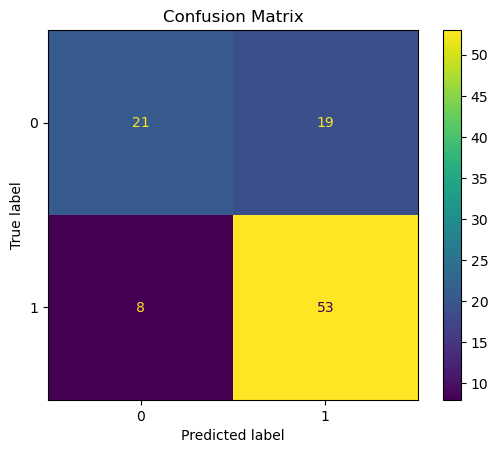

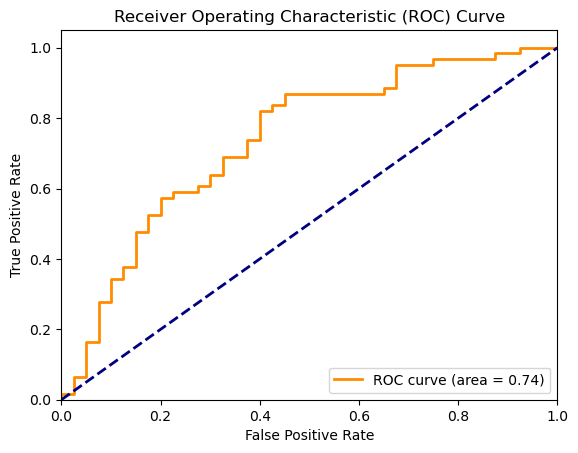

In [252]:
# LASSO 로지스틱 회귀 모델 설정
lasso_lr = LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=17)
lasso_lr.fit(X_train, y_train)

y_pred = lasso_lr.predict(X_test)
y_pred_proba = lasso_lr.predict_proba(X_test)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lasso_lr.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

get_tables(fpr, tpr)

In [253]:
df_coef = pd.DataFrame()
df_coef['name'] = df_month.columns[4:-2]
df_coef['ridge'] = ridge_lr.coef_.tolist()[0]
df_coef['lasso'] = lasso_lr.coef_.tolist()[0]

df_coef

,name,ridge,lasso
0,total_manu,4.790085,2.645510
1,dol_idx,-8.925551,-3.660987
2,m2,-14.565963,0.000000
3,unemploy,-11.870826,-4.997616
4,interest,-2.727221,-1.619140
5,copper,120.460737,105.861309
6,cpi_purch_power,12.766125,11.839606
7,dspi,-39.357526,0.000000
8,iron_ore,15.067175,0.000000
9,UMCSENT,0.502182,0.000000


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
정확도: 0.7326732673267327
정밀도: 0.75
재현도: 0.8360655737704918
최적의 파라미터: {'rf__bootstrap': False, 'rf__max_depth': 10, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
최적의 점수: 0.7946345975948196


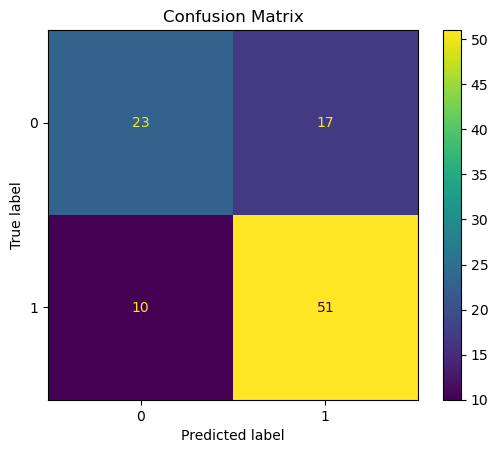

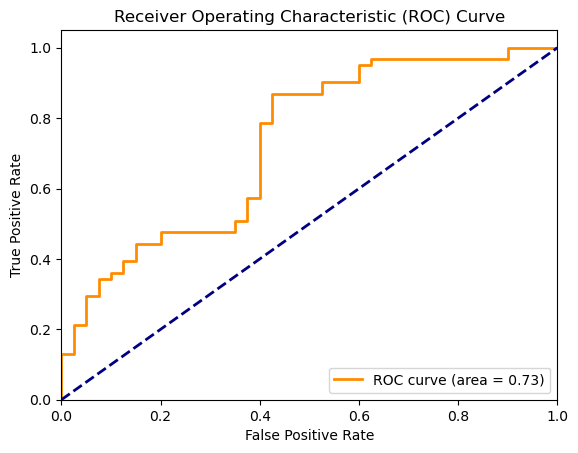

In [233]:
# Random Forest 분류

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# 파이프라인 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 데이터 스케일링
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  # 랜덤 포레스트 모델
])

param_grid = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]


print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

print("최적의 파라미터:", grid_search.best_params_)
print("최적의 점수:", grid_search.best_score_)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

정확도: 0.6435643564356436
정밀도: 0.6875
재현도: 0.7333333333333333


c:\Users\kbh11\anaconda3\Lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:627: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


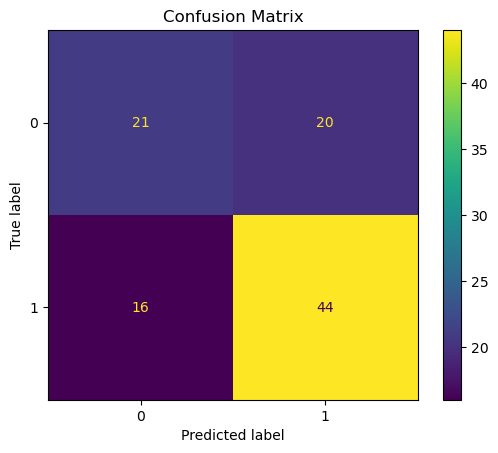

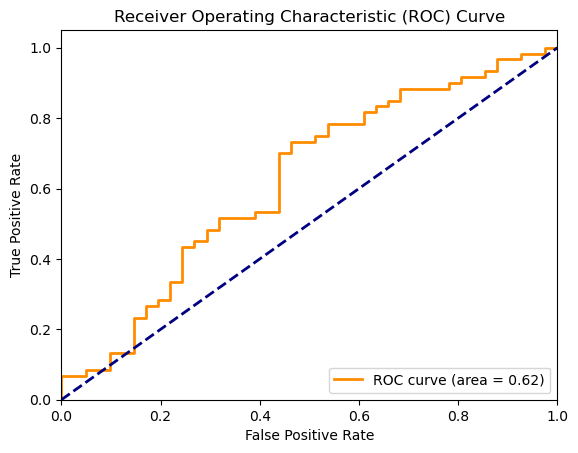

In [254]:
# 로지스틱 회귀 Ridge / 1달 후 유가

from sklearn.linear_model import LogisticRegression

df_mon_chg = df_mon_chg.dropna()

df_X = df_mon_chg.iloc[1:,4:-2]
df_y = df_mon_chg.iloc[:-1,-1]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

# Ridge 로지스틱 회귀 모델 설정
ridge_lr_1m = LogisticRegression(penalty='l2', C=3)  # C는 정규화의 역수; 낮을수록 더 강한 정규화
ridge_lr_1m.fit(X_train, y_train)

y_pred = ridge_lr_1m.predict(X_test)
y_pred_proba = ridge_lr_1m.predict_proba(X_test)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ridge_lr_1m.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

get_tables(fpr, tpr)

정확도: 0.6435643564356436
정밀도: 0.6666666666666666
재현도: 0.8


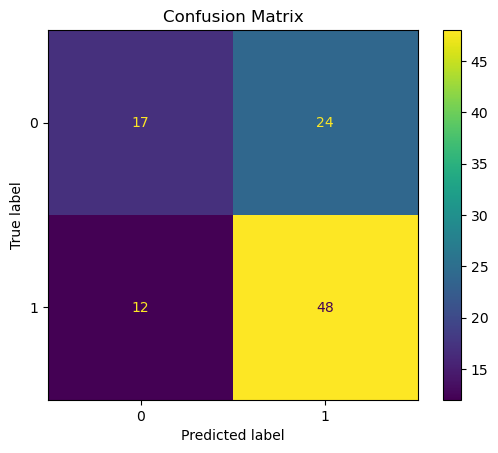

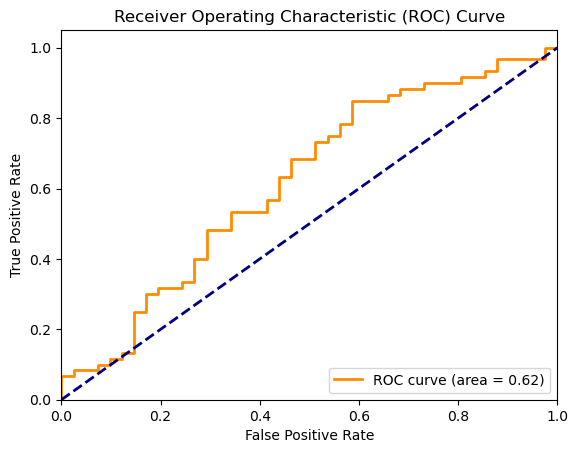

In [255]:
# LASSO 로지스틱 회귀 모델 설정
lasso_lr_1m = LogisticRegression(penalty='l1', solver='liblinear', C=10, random_state=17)
lasso_lr_1m.fit(X_train, y_train)

y_pred = lasso_lr_1m.predict(X_test)
y_pred_proba = lasso_lr_1m.predict_proba(X_test)[:,1]

print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lasso_lr_1m.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

get_tables(fpr, tpr)

In [256]:
df_coef = pd.DataFrame()
df_coef['name'] = df_month.columns[4:-2]
df_coef['ridge'] = ridge_lr_1m.coef_.tolist()[0]
df_coef['lasso'] = lasso_lr_1m.coef_.tolist()[0]

df_coef

,name,ridge,lasso
0,total_manu,10.178976,7.195601
1,dol_idx,1.583609,0.000000
2,m2,-0.674672,0.000000
3,unemploy,-0.226356,0.000000
4,interest,0.412991,0.343107
5,copper,68.631874,82.804266
6,cpi_purch_power,1.998389,1.117954
7,dspi,-34.774999,0.000000
8,iron_ore,-6.676523,0.000000
9,UMCSENT,-2.483426,-2.001112


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
정확도: 0.6633663366336634
정밀도: 0.6857142857142857
재현도: 0.8
최적의 파라미터: {'rf__bootstrap': True, 'rf__max_depth': None, 'rf__min_samples_leaf': 2, 'rf__min_samples_split': 5, 'rf__n_estimators': 50}
최적의 점수: 0.6695652173913044


c:\Users\kbh11\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


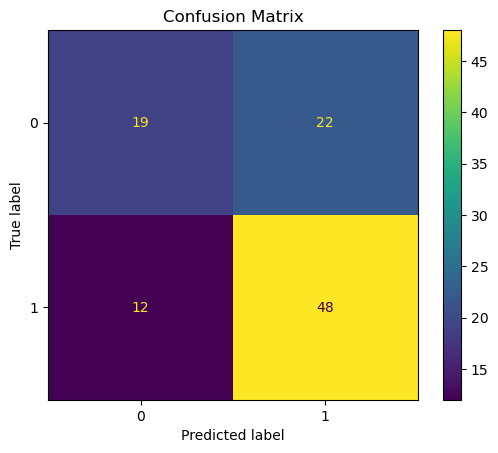

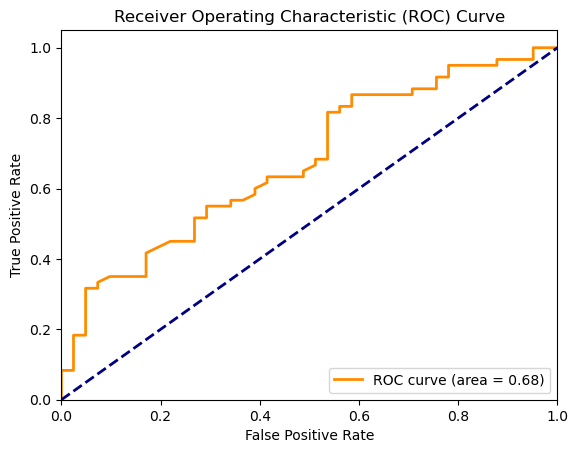

In [257]:
# Random Forest 분류 / 1달 후

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=17, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# 파이프라인 설정
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 데이터 스케일링
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))  # 랜덤 포레스트 모델
])

param_grid = {
    'rf__n_estimators': [10, 50, 100, 200],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__bootstrap': [True, False]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]


print("정확도:", accuracy_score(y_test, y_pred))
print("정밀도:", precision_score(y_test, y_pred))
print("재현도:", recall_score(y_test, y_pred))

print("최적의 파라미터:", grid_search.best_params_)
print("최적의 점수:", grid_search.best_score_)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
최적의 파라미터: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
최적의 점수: 0.6862164662349677
테스트 세트 정확도: 0.6534653465346535


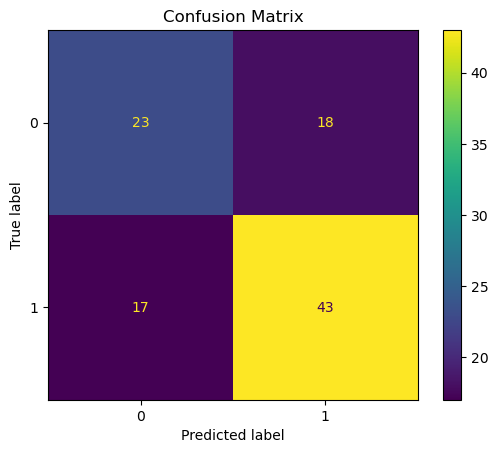

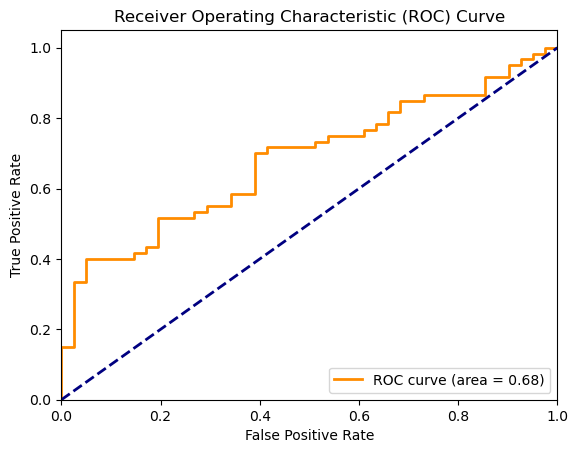

In [258]:
# XGBoost

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
}

# XGBoost 분류기 설정
xgb_clf = xgb.XGBClassifier(random_state=-17)

# GridSearchCV 설정
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)
print("최적의 파라미터:", grid_search.best_params_)
print("최적의 점수:", grid_search.best_score_)

# 최적의 모델로 예측
y_pred = grid_search.predict(X_test)
y_pred_proba = grid_search.predict_proba(X_test)[:,1]
print("테스트 세트 정확도:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot()
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

get_tables(fpr, tpr)

In [62]:
df_check = pd.DataFrame(X_test)
df_check['test'] = y_test
df_check['pred'] = y_pred

df_check = df_check[df_check['test'] != df_check['pred']]

df_index = df_check.index
df_date = df_month[df_month.index.isin(df_index)]
# df_check['year'] = df_date['year']
# df_check['month'] = df_date['month']
# order = ['year', 'month', 'total_manu', 'dol_idx', 'm2', 'unemploy', 'interest', 'ppi_total_manu',
#        'copper', 'cpi_purch_power', 'dspi', 'iron_ore', 'test', 'pred', ]
# df_check = df_check[order]
df_check.head()

,total_manu,dol_idx,m2,unemploy,interest,ppi_total_manu,copper,cpi_purch_power,dspi,iron_ore,...,conflicts,world_crude_production,opec_production,non_opec_producion,opec_pro_ratio,world_consumption,oecd_consumption,china_consumption,test,pred
226,0.015735,0.007006,0.010460,-0.040000,0.424933,-0.006084,-0.036010,-0.002364,0.004744,0.032340,...,0.039281,0.000898,0.013993,-0.006783,0.012954,-0.053268,-0.041491,-0.144597,0,1
228,0.012528,-0.008610,0.004985,0.020408,-0.034422,0.003358,0.077236,-0.004739,0.002338,0.216269,...,-0.152362,-0.001941,0.003073,-0.005002,0.005024,-0.009785,-0.012563,-0.042456,0,1
233,0.007926,-0.012348,0.006720,0.020833,0.013180,-0.004907,-0.023276,-0.002404,0.002564,0.062120,...,-0.046230,-0.007663,-0.004333,-0.009789,0.003356,0.033174,0.033935,0.053691,0,1
236,-0.041877,0.020120,0.005308,-0.040816,0.025766,-0.002722,0.152110,0.000000,0.003013,0.257564,...,-0.009783,0.012201,0.010197,0.013485,-0.001980,0.021092,0.011986,0.118512,1,0
237,0.024088,0.023146,0.002496,0.000000,0.327869,0.003821,0.038419,0.000000,0.004534,0.071429,...,-0.251941,-0.006091,-0.003582,-0.007692,0.002524,0.014419,0.019882,0.046404,0,1
